# Node Classification: Comparing Network Representation Methods

This tutorial compares three approaches for node classification on networks:

1. **Traditional network metrics**: Hand-crafted features like degree, clustering coefficient, and centrality measures
2. **Graphlet-based features**: Counting small subgraph patterns around each node  
3. **Node2vec embeddings**: Learning node representations through biased random walks

We'll use Zachary's Karate Club network to predict which faction members joined after the club split.

In [1]:
import torch
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import random
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

from torch_geometric.nn.models import Node2Vec

# Set seeds for reproducibility
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

nepoch = 200  # Number of epochs for node2vec training

In [2]:
# Utility functions for data loading
def load_karate_club():
    """Load Zachary's Karate Club network"""
    return nx.karate_club_graph()

def get_edge_index(G):
    """Convert NetworkX graph edges to PyTorch Geometric format"""
    return torch.tensor(list(G.edges()), dtype=torch.long).t().contiguous()

def get_nodes_and_labels(G):
    """Extract nodes and faction labels from the graph"""
    nodes = list(G.nodes())
    label_map = {'Mr. Hi': 0, 'Officer': 1}
    labels = np.array([label_map[G.nodes[v]['club']] for v in nodes])
    return nodes, labels

In [3]:
# Cross-validation evaluation function (used for all methods)
def cv_score(features, labels):
    """
    Evaluate features using stratified k-fold cross-validation.
    
    Parameters:
    - features: Feature matrix, shape (num_samples, num_features)
    - labels: Ground truth labels for classification
    
    Returns:
    - Mean accuracy score across all folds
    """
    scaler = StandardScaler()
    X = scaler.fit_transform(features)
    y = labels

    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    scores = []
    for train_idx, test_idx in skf.split(X, y):
        Xtr, Xte = X[train_idx], X[test_idx]
        ytr, yte = y[train_idx], y[test_idx]

        clf = LogisticRegression(max_iter=1000, random_state=42)
        clf.fit(Xtr, ytr)
        preds = clf.predict(Xte)
        scores.append(accuracy_score(yte, preds))
    return np.mean(scores)

## 1. Data Preparation

First, let's load the Karate Club graph and visualize the network with faction labels:

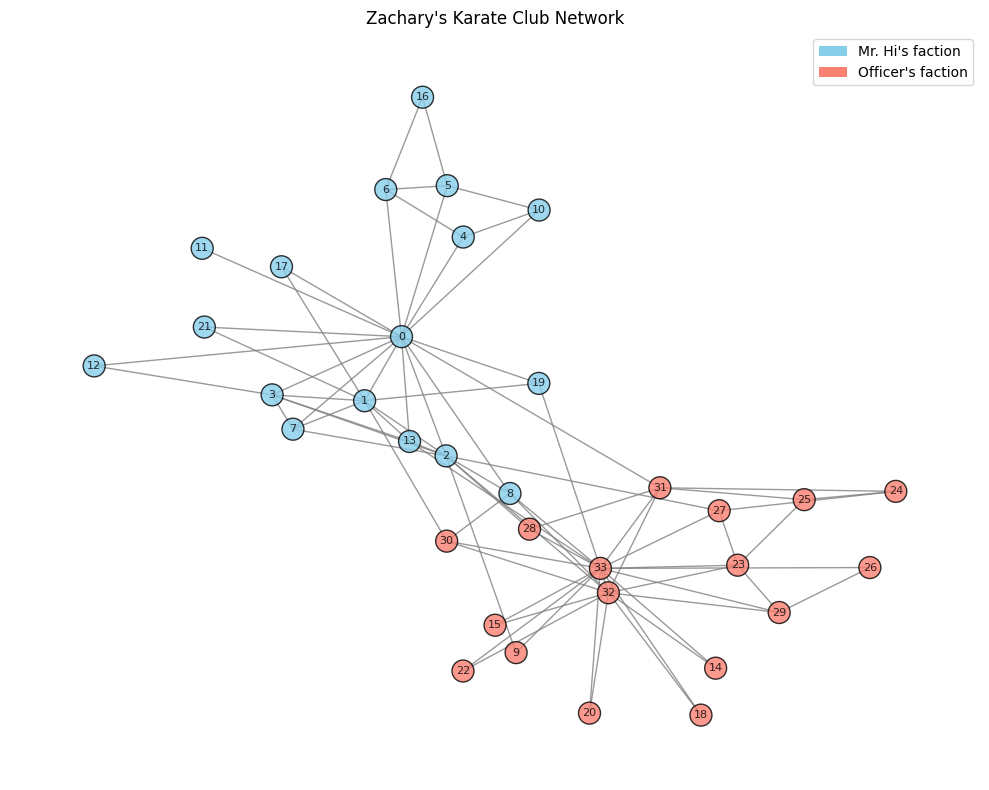

In [4]:
# Load the graph and prepare data
G = load_karate_club()
edge_index = get_edge_index(G)
nodes, labels = get_nodes_and_labels(G)

# Visualize the network
plt.figure(figsize=(10, 8))
pos = nx.spring_layout(G, seed=42)
node_colors = ['skyblue' if l == 0 else 'salmon' for l in labels]
nx.draw_networkx(G, pos, node_color=node_colors, 
                 node_size=250, font_size=8, alpha=0.8, edge_color='gray', 
                 with_labels=True, edgecolors='black', linewidths=1.0)

# Add legend
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor='skyblue', label="Mr. Hi's faction"),
                   Patch(facecolor='salmon', label="Officer's faction")]
plt.legend(handles=legend_elements, loc='upper right')
plt.title("Zachary's Karate Club Network")
plt.axis('off')
plt.tight_layout()

In [5]:
print(f"Network statistics:")
print(f"  Nodes: {G.number_of_nodes()}")
print(f"  Edges: {G.number_of_edges()}")
print(f"  Faction distribution: {np.bincount(labels)}")

Network statistics:
  Nodes: 34
  Edges: 78
  Faction distribution: [17 17]


## 2. Traditional Network Features

Network science provides many metrics to characterize nodes. We'll extract:

- **Degree**: Number of connections
- **Clustering coefficient**: How connected a node's neighbors are to each other
- **Betweenness centrality**: How many shortest paths go through a node
- **Eigenvector centrality**: Influence of a node based on its connections

These basic measurements have been used historically for node classification.

In [6]:
def extract_traditional_features(G):
    """Extract enhanced network science features for each node"""
    print("Extracting enhanced traditional network features...")
    features = {}
    
    # Compute standard node metrics
    degree = dict(G.degree())
    clustering = nx.clustering(G)
    betweenness = nx.betweenness_centrality(G)
    eigenvector = nx.eigenvector_centrality(G)
    
    # Add more powerful metrics
    closeness = nx.closeness_centrality(G)
    pagerank = nx.pagerank(G)
    
    # Add local structural features
    # Count triangles per node
    triangles = nx.triangles(G)
    
    # Compute core number - k-core decomposition value
    core_number = nx.core_number(G)
    
    # Eccentricity - maximum distance to any node
    try:
        eccentricity = nx.eccentricity(G)
    except:
        # Handle disconnected graphs
        eccentricity = {n: 0 for n in G.nodes()}
    
    # Collect features for each node
    for node in G.nodes():
        # Get neighbors degree statistics
        neighbor_degrees = [degree[neigh] for neigh in G.neighbors(node)]
        avg_neigh_degree = np.mean(neighbor_degrees) if neighbor_degrees else 0
        
        features[node] = [
            degree[node],                    # Degree centrality
            clustering[node],                # Clustering coefficient
            triangles[node],                 # Number of triangles
            betweenness[node],               # Betweenness centrality
            closeness[node],                 # Closeness centrality
            eigenvector[node],               # Eigenvector centrality
            eccentricity.get(node, 0),       # Eccentricity
            avg_neigh_degree,                # Average neighbor degree
        ]
    
    # Convert to numpy array
    nodes = sorted(features.keys())
    X = np.array([features[node] for node in nodes])
    
    print(f"Enhanced feature set: {X.shape[1]} metrics per node")
    return X

# Extract improved traditional features
traditional_features = extract_traditional_features(G)

Extracting enhanced traditional network features...
Enhanced feature set: 8 metrics per node


In [7]:
# Evaluate traditional features 
traditional_score = cv_score(traditional_features, labels)
print(f"Traditional features cross-validation accuracy: {traditional_score:.4f}")

Traditional features cross-validation accuracy: 0.8238


## 3. Graphlet-Based Features

Graphlets are small, connected, non-isomorphic induced subgraphs of a larger network. 
By counting different graphlet patterns around each node, we capture rich structural information.

This approach goes beyond simple metrics by capturing the local topology patterns around each node.

In [8]:
import itertools
from networkx.algorithms.isomorphism import GraphMatcher
from networkx.algorithms.graph_hashing import weisfeiler_lehman_graph_hash

def get_connected_templates(max_k=5):
    """Get all connected graphlets of size 2 to max_k from the graph atlas"""
    atlas = nx.graph_atlas_g()
    templates = {k: [] for k in range(2, max_k + 1)}
    for H in atlas:
        n = H.number_of_nodes()
        if 2 <= n <= max_k and nx.is_connected(H):
            # relabel nodes to 0..n-1
            T = nx.convert_node_labels_to_integers(H)
            templates[n].append(T)
    return templates

def group_by_wl_and_degree(templates):
    """Group templates by WL hash and degree sequence for efficient matching"""
    wl_groups = {}
    deg_groups = {}
    orbits_map = {}
    for k, tlist in templates.items():
        wl_map = {}
        deg_map = {}
        orbit_list = []
        for tidx, T in enumerate(tlist):
            # WL-hash pruning
            h = weisfeiler_lehman_graph_hash(T, iterations=2)
            wl_map.setdefault(h, []).append(tidx)
            # degree-sequence pruning
            seq = tuple(sorted(dict(T.degree()).values()))
            deg_map.setdefault(seq, []).append(tidx)
            # compute template orbits (sets of symmetric positions)
            GM = GraphMatcher(T, T)
            autos = list(GM.isomorphisms_iter())
            unassigned = set(T.nodes())
            orbits = []
            while unassigned:
                seed = unassigned.pop()
                orbit = {seed}
                changed = True
                while changed:
                    changed = False
                    for auto in autos:
                        for u in list(orbit):
                            v = auto[u]
                            if v not in orbit:
                                orbit.add(v)
                                changed = True
                orbits.append(sorted(orbit))
                unassigned -= orbit
            orbit_list.append(orbits)
        wl_groups[k] = wl_map
        deg_groups[k] = deg_map
        orbits_map[k] = orbit_list
    return wl_groups, deg_groups, orbits_map

def build_orbit_features(G, nodes, templates, wl_groups, deg_groups, orbits_map, max_k=5):
    """Count occurrences of each orbit position for each node"""
    n = len(nodes)
    idx_of = {v: i for i, v in enumerate(nodes)}
    
    # Build feature index
    feature_idx = {}
    feature_names = []
    col = 0
    for k, tlist in templates.items():
        for tidx, orbits in enumerate(orbits_map[k]):
            for oidx, _ in enumerate(orbits):
                feature_idx[(k, tidx, oidx)] = col
                feature_names.append(f"g{k}_t{tidx}_o{oidx}")
                col += 1

    X = np.zeros((n, col), dtype=int)

    # Count subgraphs
    for k in range(2, max_k + 1):
        print(f"Counting connected size-{k} subgraphs...")
        for combo in itertools.combinations(nodes, k):
            H = G.subgraph(combo)
            if not nx.is_connected(H):
                continue
            # prune by degree sequence
            seq = tuple(sorted(dict(H.degree()).values()))
            if seq not in deg_groups[k]:
                continue
            # prune by WL-hash
            h = weisfeiler_lehman_graph_hash(H, iterations=2)
            if h not in wl_groups[k]:
                continue
            # try to match with templates
            for tidx in wl_groups[k][h]:
                if tidx not in deg_groups[k][seq]:
                    continue
                T = templates[k][tidx]
                GM = GraphMatcher(H, T)
                if not GM.is_isomorphic():
                    continue
                mapping = GM.mapping   # H-node -> T-node
                inv_map = {t: h for h, t in mapping.items()}
                # increment counts for each orbit position
                for oidx, orbit in enumerate(orbits_map[k][tidx]):
                    c = feature_idx[(k, tidx, oidx)]
                    for tn in orbit:
                        gnode = inv_map[tn]
                        X[idx_of[gnode], c] += 1
                break
    return X, feature_names

In [9]:
# Extract graphlet features
print("Extracting graphlet features (this may take a moment)...")
templates = get_connected_templates(max_k=5)
print(f"Found {sum(len(v) for v in templates.values())} graphlet templates of sizes 2-5")

wl_groups, deg_groups, orbits_map = group_by_wl_and_degree(templates)
X_graphlets, feat_names = build_orbit_features(G, nodes, templates, wl_groups, deg_groups, orbits_map, max_k=5)

print(f"Extracted {X_graphlets.shape[1]} graphlet features per node")

Extracting graphlet features (this may take a moment)...
Found 30 graphlet templates of sizes 2-5
Counting connected size-2 subgraphs...
Counting connected size-3 subgraphs...
Counting connected size-4 subgraphs...
Counting connected size-5 subgraphs...
Extracted 73 graphlet features per node


In [10]:
# Evaluate graphlet features using cross-validation
graphlet_score = cv_score(X_graphlets, labels)
print(f"Graphlet features cross-validation accuracy: {graphlet_score:.4f}")

Graphlet features cross-validation accuracy: 0.8571


## 4. Node2Vec Embeddings

Node2vec learns continuous feature representations for nodes by optimizing a neighborhood preserving objective. 
It uses biased random walks to explore diverse neighborhoods and learns embeddings that maximize the likelihood 
of preserving network neighborhoods.

Key parameters:
- p: Return parameter (lower values encourage revisiting previous nodes)
- q: In-out parameter (lower values encourage outward exploration) 
- embedding_dim: Size of the learned embeddings
- walk_length: Length of each random walk
- context_size: Context window size for the Skip-gram model

In [11]:
def train_node2vec(edge_index, embedding_dim, walk_length,
                  context_size, walks_per_node, negative_samples, 
                  p=1.0, q=1.0, epochs=None):
    """
    Train node2vec model and return node embeddings
    
    Parameters:
    - p: Return parameter (controls likelihood of revisiting nodes)
    - q: In-out parameter (controls BFS vs DFS-like exploration)
    """
    if epochs is None:
        epochs = nepoch
        
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    model = Node2Vec(
        edge_index,
        embedding_dim=embedding_dim,
        walk_length=walk_length,
        context_size=context_size,
        walks_per_node=walks_per_node,
        num_negative_samples=negative_samples,
        p=p,  # Return parameter
        q=q,  # In-out parameter
        sparse=True
    ).to(device)

    loader = model.loader(batch_size=128, shuffle=True)
    optimizer = torch.optim.SparseAdam(model.parameters(), lr=0.01)

    model.train()
    for epoch in range(1, epochs+1):
        total_loss = 0
        for pos_rw, neg_rw in loader:
            optimizer.zero_grad()
            loss = model.loss(pos_rw.to(device), neg_rw.to(device))
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        if epoch % 20 == 0 or epoch == 1:
            print(f"  epoch {epoch:3d}/{epochs}  loss={total_loss:.4f}")
    model.eval()
    with torch.no_grad():
        emb = model().cpu().numpy()
    return emb

In [12]:
# Define expanded hyperparameter grid for node2vec including p and q
param_grid = {
    'embedding_dim': [8],          # Fixed to reduce computation time
    'walk_length': [8],            # Fixed to reduce computation time  
    'context_size': [4],           # Context size for optimization
    'walks_per_node': [20],        # Number of walks per node
    'negative_samples': [2],       # Number of negative samples
    'p': [0.25, 0.5, 1.0, 2.0, 4.0], # Return parameter values
    'q': [0.25, 0.5, 1.0, 2.0, 4.0]  # In-out parameter values
}

# Perform grid search to find best parameters
print(f"🔎 Starting hyperparameter search for Node2Vec p and q parameters...")
best_score = 0.0
best_params = None
best_emb = None
pq_results = []

# Create a grid of (p,q) combinations to test
pq_scores = np.zeros((len(param_grid['p']), len(param_grid['q'])))
p_idx_map = {p: i for i, p in enumerate(param_grid['p'])}
q_idx_map = {q: i for i, q in enumerate(param_grid['q'])}

# We'll use abbreviated grid search to save time
for p in param_grid['p']:
    for q in param_grid['q']:
        params = {
            'embedding_dim': 8,
            'walk_length': 8,
            'context_size': 4,
            'walks_per_node': 20,
            'negative_samples': 2,
            'p': p,
            'q': q
        }
        print(f"Training with p={p}, q={q}...")
        
        emb = train_node2vec(
            edge_index,
            embedding_dim=params['embedding_dim'],
            walk_length=params['walk_length'],
            context_size=params['context_size'],
            walks_per_node=params['walks_per_node'],
            negative_samples=params['negative_samples'],
            p=params['p'],
            q=params['q']
        )
        score = cv_score(emb, labels)
        print(f" → Cross-validation accuracy: {score:.4f}\n")
        pq_results.append((p, q, score))
        pq_scores[p_idx_map[p], q_idx_map[q]] = score
        
        if score > best_score:
            best_score = score
            best_params = params
            best_emb = emb

# Show grid search results
print(f"✅ Node2Vec p,q grid search complete")
print(f"Best CV accuracy: {best_score:.4f}")
print(f"Best parameters: p={best_params['p']}, q={best_params['q']}")

🔎 Starting hyperparameter search for Node2Vec p and q parameters...
Training with p=0.25, q=0.25...
  epoch   1/200  loss=1.8488
  epoch  20/200  loss=1.3850
  epoch  40/200  loss=1.1484
  epoch  60/200  loss=1.0219
  epoch  80/200  loss=0.9580
  epoch 100/200  loss=0.9226
  epoch 120/200  loss=0.8865
  epoch 140/200  loss=0.8702
  epoch 160/200  loss=0.8515
  epoch 180/200  loss=0.8434
  epoch 200/200  loss=0.8332
 → Cross-validation accuracy: 0.8857

Training with p=0.25, q=0.5...
  epoch   1/200  loss=1.8426
  epoch  20/200  loss=1.4419
  epoch  40/200  loss=1.1744
  epoch  60/200  loss=1.0364
  epoch  80/200  loss=0.9524
  epoch 100/200  loss=0.8976
  epoch 120/200  loss=0.8680
  epoch 140/200  loss=0.8530
  epoch 160/200  loss=0.8452
  epoch 180/200  loss=0.8331
  epoch 200/200  loss=0.8311
 → Cross-validation accuracy: 0.9429

Training with p=0.25, q=1.0...
  epoch   1/200  loss=2.0979
  epoch  20/200  loss=1.5434
  epoch  40/200  loss=1.2791
  epoch  60/200  loss=1.1119
  epoch 

## 5. Comparison of Methods

Now we compare all three approaches to see which method provides the best node classification performance:

In [13]:
# Create a comparison table and visualize results
methods = ['Traditional Features', 'Graphlet Features', 'Node2Vec']
accuracies = [traditional_score, graphlet_score, best_score]
improvements = [0, (graphlet_score-traditional_score)*100, (best_score-traditional_score)*100]

# Print summary table
print("="*60)
print("Method Comparison - Cross-validation Accuracy")
print("="*60)
print(f"{'Method':<20} {'Accuracy':<10} {'Improvement':<12}")
print("-"*60)
for m, acc, imp in zip(methods, accuracies, improvements):
    print(f"{m:<20} {acc:.4f}      {imp:+.2f}%")
print("="*60)

Method Comparison - Cross-validation Accuracy
Method               Accuracy   Improvement 
------------------------------------------------------------
Traditional Features 0.8238      +0.00%
Graphlet Features    0.8571      +3.33%
Node2Vec             0.9429      +11.90%


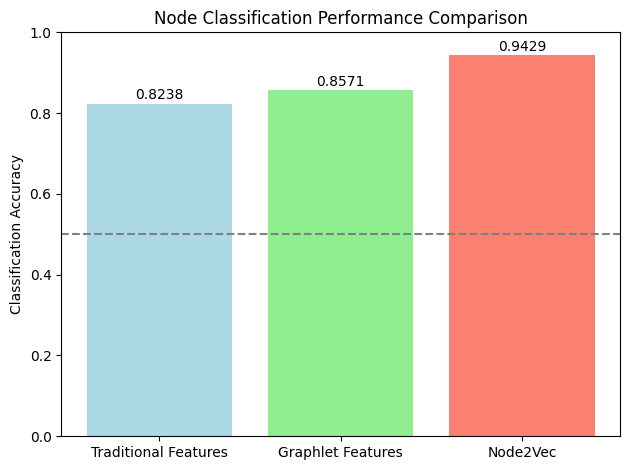

In [14]:
# Plot results
plt.figure()
bars = plt.bar(methods, accuracies, color=['lightblue', 'lightgreen', 'salmon'])
plt.ylim(0, 1.0)
plt.axhline(y=0.5, linestyle='--', color='gray')
plt.ylabel('Classification Accuracy')
plt.title('Node Classification Performance Comparison')

# Add accuracy values on top of each bar
for bar, acc in zip(bars, accuracies):
    plt.text(bar.get_x() + bar.get_width()/2, 
             bar.get_height() + 0.01,
             f'{acc:.4f}',
             ha='center')

plt.tight_layout()
plt.show()

## Conclusion

This comparison highlights how different node representation approaches perform for node classification tasks:

1. **Traditional features** provide a simple baseline using hand-crafted metrics, but often miss complex structural patterns in the network.

2. **Graphlet features** capture local topological patterns by counting subgraph occurrences, significantly improving over traditional metrics.

3. **Node2vec embeddings** learn representations automatically through biased random walks and produce the best results overall, demonstrating the power of representation learning approaches.

Key takeaways:
- The structure of network neighborhoods contains valuable information for node classification
- Representation learning methods can automatically discover useful features
- More complex methods generally outperform simpler hand-crafted features
- The choice of method depends on the specific task, data size, and computational constraints